### DSFC15 - Sprint 1 Final Output of Group 3
#### This output aims to use machine learning algorithm to predict whether a customer will churn or not based on RFM features such as recency, frequency, and monetary value.
#### Detailed analysis and considerations are stated on the notebook.

In [92]:
# Import libraries to be used on the notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Read the CSV files
df = pd.read_csv('cc_clean.csv')
df_dirty = pd.read_csv('cc_dirty.csv')
df_rfm = pd.read_csv('cc_rfm.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92432 entries, 0 to 92431
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cc_num          92432 non-null  float64
 1   gender          92432 non-null  object 
 2   city            92432 non-null  object 
 3   city_pop        92432 non-null  int64  
 4   job             92432 non-null  object 
 5   dob             92432 non-null  object 
 6   acct_num        92432 non-null  float64
 7   acct_num2       92432 non-null  int64  
 8   trans_num       92432 non-null  object 
 9   unix_time       92432 non-null  int64  
 10  category        85391 non-null  object 
 11  amt             92432 non-null  float64
 12  trans_datetime  92432 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 9.2+ MB


#### Data Cleaning

In [4]:
# Rename NA values under "category" to be "Others"
df['category'].replace(np.nan, 'Others', inplace=True)

# Drop "acct_num" column
df.drop(columns= ['acct_num'], inplace= True)

# Rename acct_num2 to acct_num
df.rename(columns = {'acct_num2' : 'acct_num'}, inplace = True)

# Convert trans_datetime from object to datetime.
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])

C:\Users\User\AppData\Local\Temp\ipykernel_7080\3675714906.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category'].replace(np.nan, 'Others', inplace=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92432 entries, 0 to 92431
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cc_num          92432 non-null  float64       
 1   gender          92432 non-null  object        
 2   city            92432 non-null  object        
 3   city_pop        92432 non-null  int64         
 4   job             92432 non-null  object        
 5   dob             92432 non-null  object        
 6   acct_num        92432 non-null  int64         
 7   trans_num       92432 non-null  object        
 8   unix_time       92432 non-null  int64         
 9   category        92432 non-null  object        
 10  amt             92432 non-null  float64       
 11  trans_datetime  92432 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 8.5+ MB


#### Feature Engineering

In [6]:
# Get the transaction hour, day, and month
df['trans_hour'] = pd.to_datetime(df['trans_datetime']).dt.hour
df['trans_day'] = pd.to_datetime(df['trans_datetime']).dt.day_name()
df['trans_month'] = pd.to_datetime(df['trans_datetime']).dt.month_name()

In [55]:
# Compute for the recency assuming that today is January 1, 2022.
cur_date = pd.to_datetime('2022-01-01 00:00:00')

df['recency'] = (cur_date - df['trans_datetime']).dt.days

In [56]:
# Create a column that will be used to tag if transaction is within four months or not.
four_months_ago = cur_date - pd.DateOffset(months=4)

is_within_four_months = (df['trans_datetime'] >= four_months_ago)

df['within_four'] = is_within_four_months.astype(int)

# Create a column that will be used to calculate the transaction amount within the last six months.
df['amt_within_four'] = df['amt'] * df['within_four']

In [57]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt,trans_datetime,trans_hour,trans_day,trans_month,recency,within_four,amt_within_four,hour_category,day_category
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31,13,Monday,February,690,0,0.0,Regular,Weekday Spend
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28,13,Sunday,May,579,0,0.0,Regular,Weekend Spend
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37,13,Sunday,March,642,0,0.0,Regular,Weekend Spend
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59,16,Monday,September,459,0,0.0,Regular,Weekday Spend
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50,12,Friday,July,532,0,0.0,Regular,Weekday Spend


In [22]:
# Categorizing Early Bird, Night Owl, and Weekend Spenders
map_spend = {
    6 : 'Early Bird',
    7 : 'Early Bird',
    8 : 'Early Bird',
    22 : 'Night Owl',
    23 : 'Night Owl',
    0 : 'Night Owl',
    1 : 'Night Owl',
}

map_day = {
    'Saturday' : 'Weekend Spend',
    'Sunday' : 'Weekend Spend'
}

df['hour_category'] = df['trans_hour'].map(map_spend).fillna('Regular')
df['day_category'] = df['trans_day'].map(map_day).fillna('Weekday Spend')

In [24]:
df['day_category'].value_counts()

day_category
Weekday Spend    56099
Weekend Spend    36333
Name: count, dtype: int64

In [25]:
weekend_df = df.pivot_table(index='acct_num',
                          columns='day_category',
                          values='amt',
                          aggfunc='count').fillna(0)

hour_df = df.pivot_table(index='acct_num',
                          columns='hour_category',
                          values='amt',
                          aggfunc='count').fillna(0)

merged_df = pd.merge(weekend_df, hour_df, on='acct_num')

,Weekday Spend,Weekend Spend,Early Bird,Night Owl,Regular
acct_num,,,,,
3843260959,1214.0,748.0,221.0,225.0,1516.0
20386303916,5.0,7.0,7.0,1.0,4.0
24058295524,11.0,0.0,8.0,0.0,3.0
34614744133,407.0,242.0,82.0,71.0,496.0
38399733986,390.0,257.0,83.0,82.0,482.0
...,...,...,...,...,...
968000000000,1226.0,727.0,229.0,250.0,1474.0
969000000000,381.0,267.0,74.0,100.0,474.0
971000000000,1133.0,817.0,213.0,251.0,1486.0


In [98]:
# Exploring whether
segment_df = new_df = pd.DataFrame(index=merged_df.index)

segment_df['Day_Segment'] = np.where(merged_df['Weekday Spend'] >= merged_df['Weekend Spend'], 'Weekday Spender', 'Weekend Spender')

hour_columns = ['Early Bird', 'Night Owl', 'Regular']
segment_df['Hour_Segment'] = merged_df[hour_columns].idxmax(axis=1)

segment_df

,Day_Segment,Hour_Segment
acct_num,,
3843260959,Weekday Spender,Regular
20386303916,Weekend Spender,Early Bird
24058295524,Weekday Spender,Early Bird
34614744133,Weekday Spender,Regular
38399733986,Weekday Spender,Regular
...,...,...
968000000000,Weekday Spender,Regular
969000000000,Weekday Spender,Regular
971000000000,Weekday Spender,Regular


In [45]:
final_df = df.groupby('acct_num').agg(
    total_amt = ('amt', 'sum'),
    recency = ('recency', 'min'),
    frequency = ('trans_num', 'size'),
    four_mo_freq = ('within_four', 'sum')
)

# Labelling the dataframe for churn
final_df['churn'] = np.where(final_df['four_mo_freq'] == 0, 1, 0)

In [86]:
X = final_df[['recency', 'frequency']]
y = final_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=18))
])

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=18)

accuracy_scores = cross_val_score(pipeline, X_test, y_test, cv=kfold, scoring='accuracy')

print(f"Accuracy Scores per Fold: {np.round(accuracy_scores, 3)}")
print(f"Mean Accuracy: {accuracy_scores.mean():.3f}")
print(f"Standard Deviation of Accuracy: {accuracy_scores.std():.3f}")
print("-" * 30)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy on Test Set: {final_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))


Accuracy Scores per Fold: [1.    0.833 1.   ]
Mean Accuracy: 0.944
Standard Deviation of Accuracy: 0.079
------------------------------
Final Model Accuracy on Test Set: 1.0000

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         4

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [75]:
# Modifying the features to avoid data leakage
snap_date = pd.to_datetime('2021-09-01 00:00:00')

df['recency_snap'] = (snap_date - df['trans_datetime']).dt.days

df_1 = df[df['recency_snap'] > 0]

revised_df = df_1.groupby('acct_num').agg(
    recency = ('recency_snap', 'min'),
    frequency = ('trans_num', 'size'),
)

revised_df = pd.merge(revised_df, final_df['churn'], on='acct_num')

revised_df

,recency,frequency,churn
acct_num,,,
3843260959,1,1710,0
24058295524,118,11,1
34614744133,2,556,0
38399733986,1,554,0
40452162789,456,11,1
...,...,...,...
968000000000,1,1686,0
969000000000,1,562,0
971000000000,1,1670,0


In [97]:
final_df[['recency', 'frequency', 'churn']]

,recency,frequency,churn
acct_num,,,
3843260959,25,1962,0
20386303916,111,12,0
24058295524,240,11,1
34614744133,25,649,0
38399733986,25,647,0
...,...,...,...
968000000000,25,1953,0
969000000000,26,648,0
971000000000,25,1950,0


In [91]:
X = revised_df[['recency', 'frequency']]
y = revised_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=18))
])

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=18)

accuracy_scores = cross_val_score(pipeline, X_test, y_test, cv=kfold, scoring='accuracy')

print(f"Accuracy Scores per Fold: {np.round(accuracy_scores, 3)}")
print(f"Mean Accuracy: {accuracy_scores.mean():.3f}")
print(f"Standard Deviation of Accuracy: {accuracy_scores.std():.3f}")
print("-" * 30)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy on Test Set: {final_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

Accuracy Scores per Fold: [0.778 1.   ]
Mean Accuracy: 0.889
Standard Deviation of Accuracy: 0.111
------------------------------
Final Model Accuracy on Test Set: 0.9444

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.80      1.00      0.89         4

    accuracy                           0.94        18
   macro avg       0.90      0.96      0.93        18
weighted avg       0.96      0.94      0.95        18



Text(0.5, 1.0, 'Confusion Matrix')

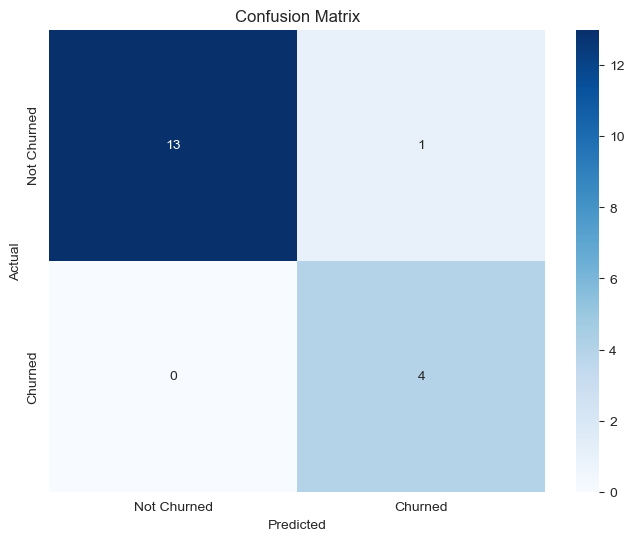

In [93]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')